<a href="https://colab.research.google.com/github/pkraison/assignment/blob/master/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

go to Runtime and change the runtime to hardware accelerators.
Runtime-->change runtime type--> runtime type(choose python3) and Hardware Accelerator(choose GPU)

In [0]:
#libraries

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [0]:
# Displaying images

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [0]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [0]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True,
                   transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, transform= torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
d = 20

class VaeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, d ** 2),
            torch.nn.ReLU(),
            torch.nn.Linear(d ** 2, d * 2)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(d, d ** 2),
            torch.nn.ReLU(),
            torch.nn.Linear(d ** 2, 784),
            torch.nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

model = VaeModel().cuda() 

In [0]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 784), size_average=False
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch: 1 Average loss: 132.1773


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


====> Test set loss: 115.7276
====> Epoch: 2 Average loss: 121.0054
====> Test set loss: 108.0213
====> Epoch: 3 Average loss: 116.1675
====> Test set loss: 105.1503
====> Epoch: 4 Average loss: 113.4887
====> Test set loss: 102.9790
====> Epoch: 5 Average loss: 111.8067
====> Test set loss: 102.3445
====> Epoch: 6 Average loss: 110.4816
====> Test set loss: 100.6171
====> Epoch: 7 Average loss: 109.5334
====> Test set loss: 99.8268
====> Epoch: 8 Average loss: 108.7860
====> Test set loss: 99.7981
====> Epoch: 9 Average loss: 108.2237
====> Test set loss: 98.5637
====> Epoch: 10 Average loss: 107.6777
====> Test set loss: 98.8388


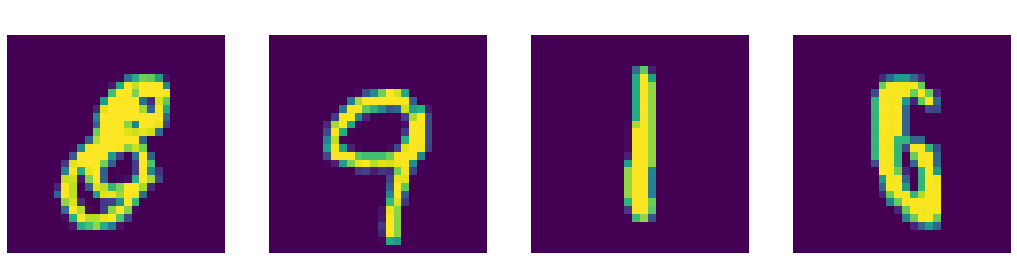

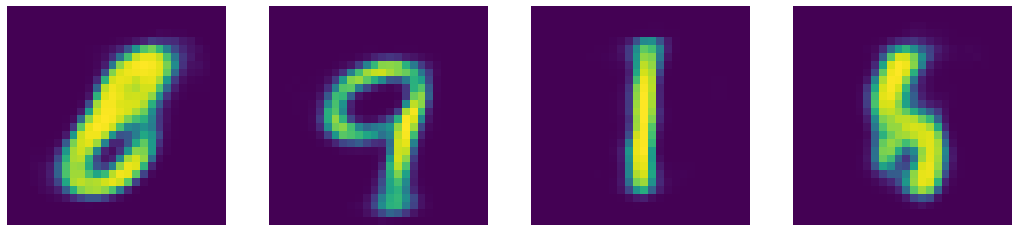

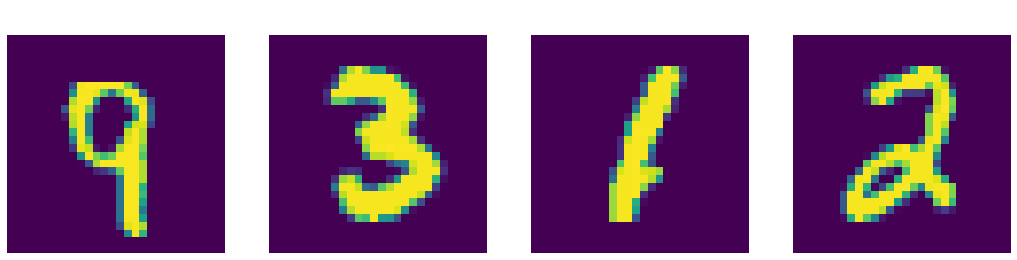

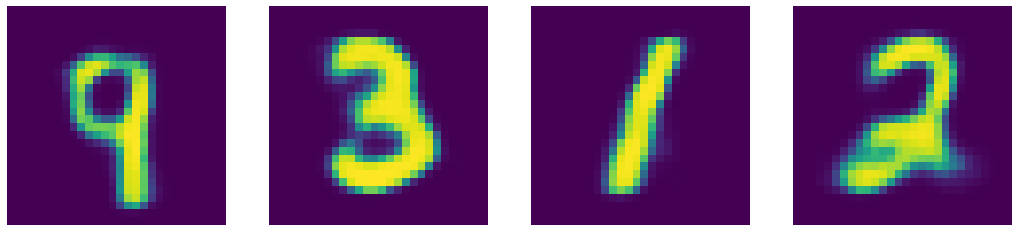

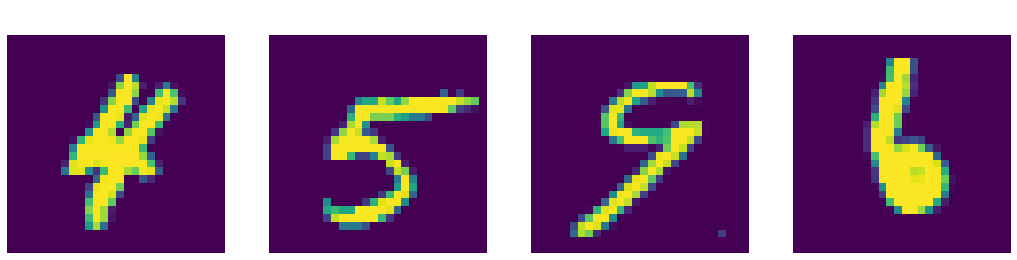

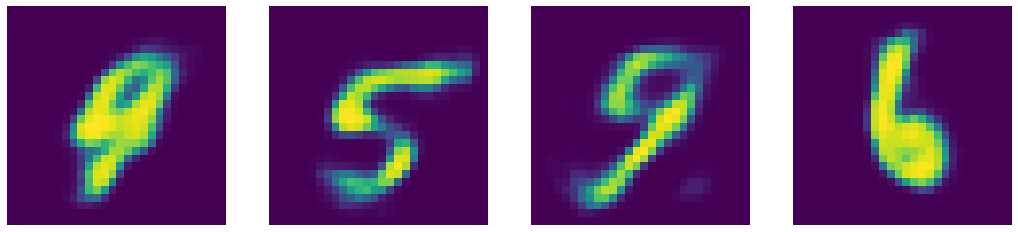

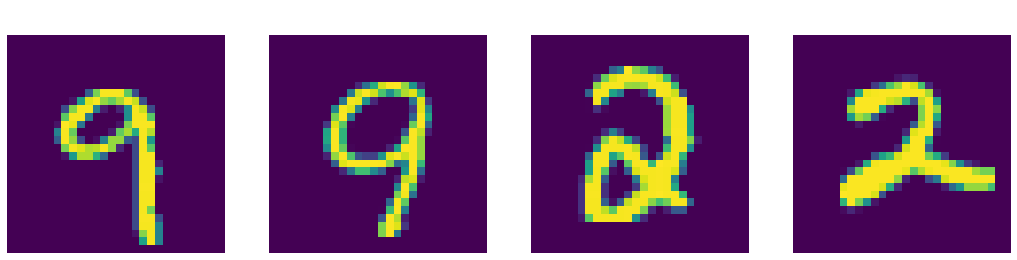

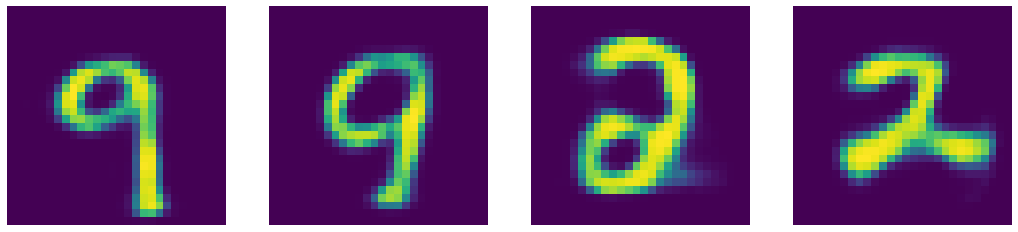

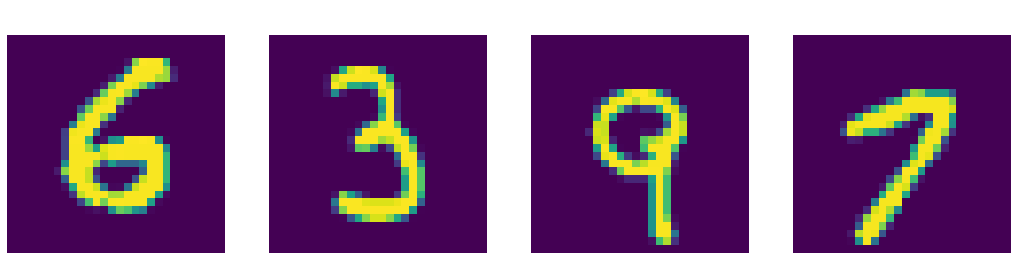

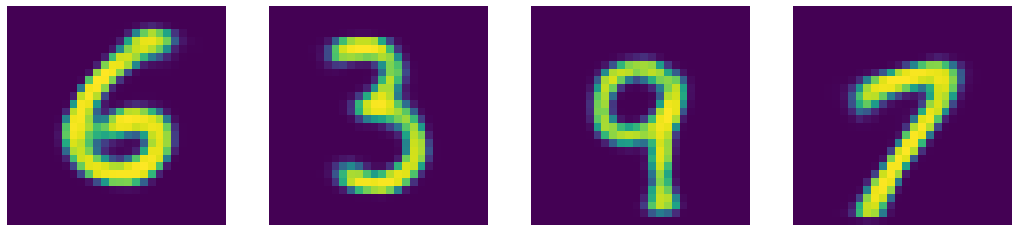

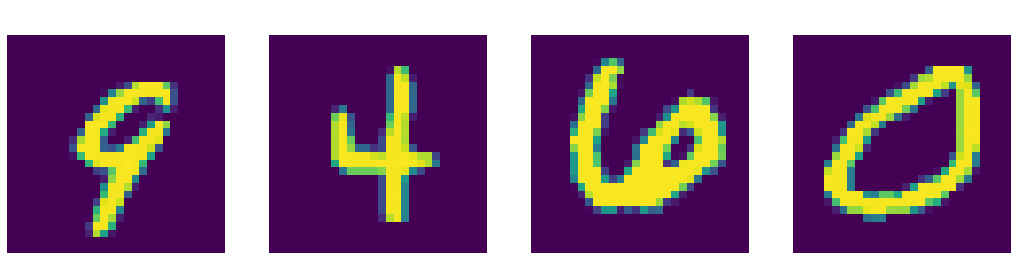

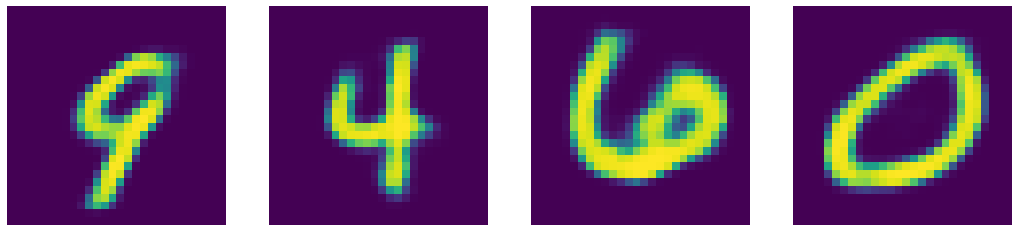

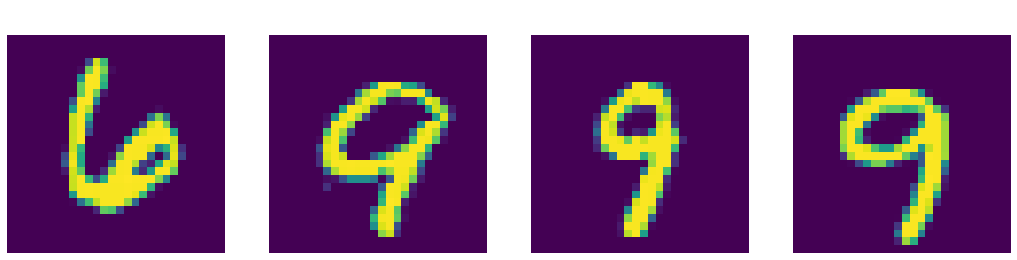

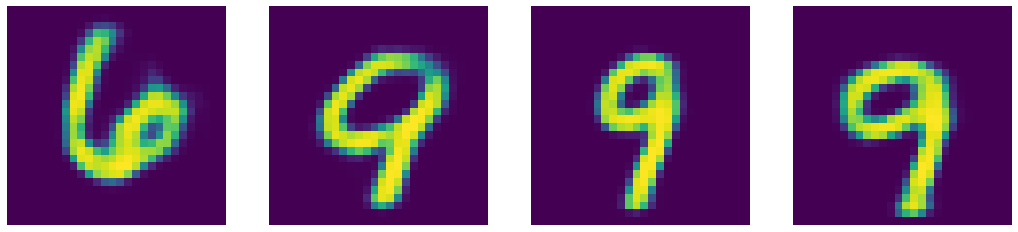

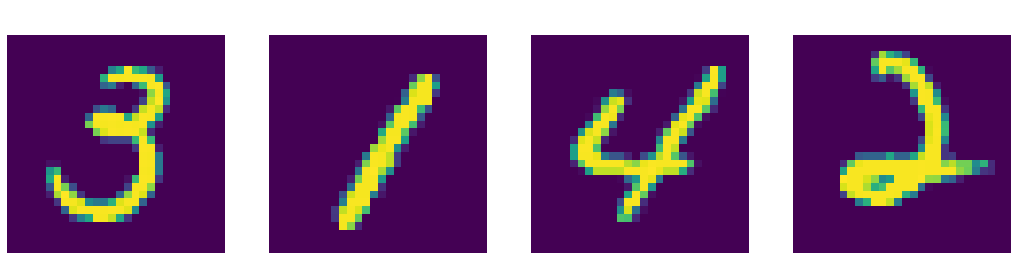

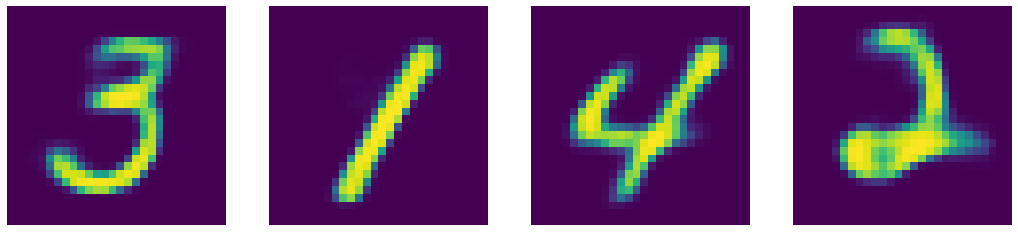

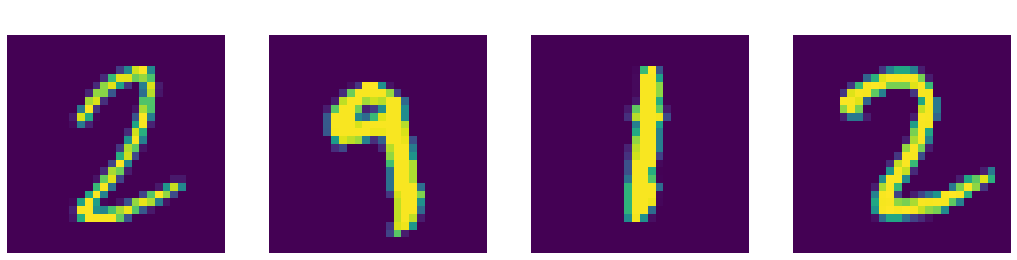

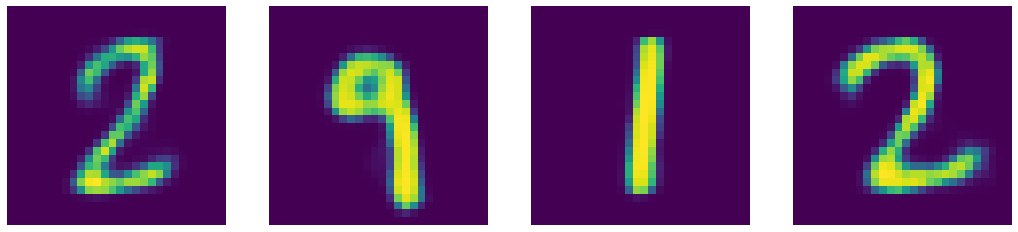

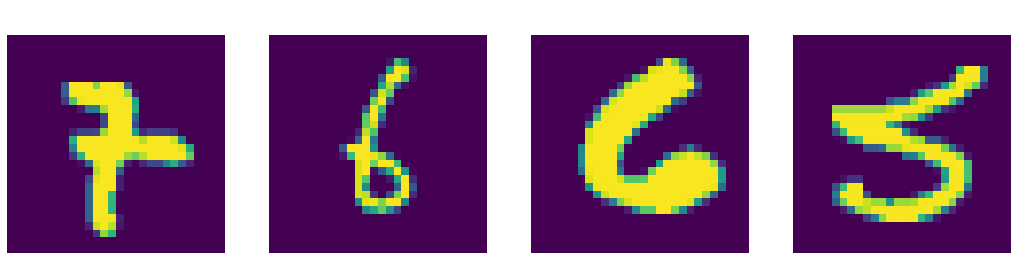

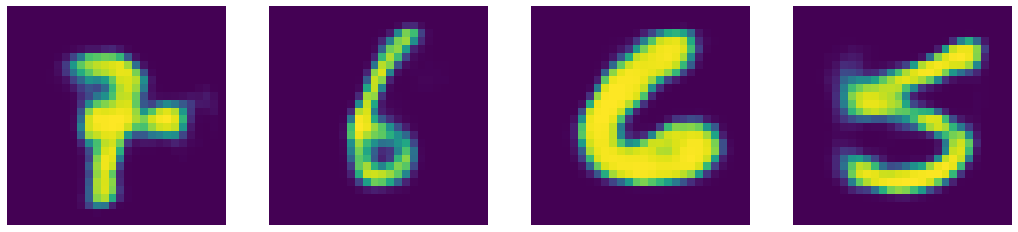

In [0]:
# Training and testing the VAE model

epochs = 10
for epoch in range(1, epochs + 1):

    # Training
    
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = Variable(data).cuda()
        #      forward
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        train_loss += loss.data.item()
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #  log
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing the model
    
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        data = Variable(data, volatile=True).cuda()
        # forward
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data.item()
    # log
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(data, recon_batch, 1, f'Epoch {epoch}')

In [0]:
# Generating a few samples

N = 16
sample = Variable(torch.randn(N, 20), volatile=True).cuda()
sample = model.decoder(sample)
display_images(None, sample, N // 4, count=True)

#display_images(None, data, 4, count=True)

NameError: ignored

In [0]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 5, 14
sample = model.decoder(Variable(torch.stack((mu[A].data, mu[B].data), 0)))
display_images(None, Variable(torch.stack(((
    data[A].data.view(-1),
    data[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0), volatile=True))

NameError: ignored

In [0]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).cuda()
for i in range(N):
    code[i] = i / N * mu[B].data + (1 - i / N) * mu[A].data
code = Variable(code, volatile=True)
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

NameError: ignored